In [7]:
import pandas as pd
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'transformers'

In [ ]:
# Requirements:

In [ ]:
class BLSTM:
    def __init__(self, data_path, name="graph2vec_BLSTM", batch_size=64, epochs=20):
        self.name = name
        self.batch_size = batch_size
        self.epochs = epochs

        # Load and preprocess data
        self._load_data(data_path)

        # Build and compile model
        self.model = self._build_model()

    def _load_data(self, data_path):
        data = pd.read_csv(data_path)  # Load graph2vec features
        print("Dataset Preview:")
        print(data.head())

        indices = data['type'].values
        y = data.iloc[:, 4]
        y_labels = y.iloc[indices]
        
        X = data.drop(columns="type")
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)
        print("Train data shape:", self.X_train.shape)
        print("Test data shape:", self.X_test.shape)
        

    def _build_model(self):
        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(self.X_train.shape[1], self.X_train.shape[2])))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Bidirectional(LSTM(64)))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=Adam(learning_rate=0.02), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
        return model

    def train(self):
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(self.name + "_best_model.weights.keras", save_best_only=True, monitor='val_loss')

        history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_test, self.y_test),
            batch_size=self.batch_size,
            epochs=self.epochs,
            callbacks=[early_stopping, model_checkpoint]
        )

        self._plot_learning_curve(history)

    def _plot_learning_curve(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.ylim(0, 1)
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.ylim(0, 2)
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()

    def test(self):
        self.model.load_weights(self.name + "_best_model.weights.keras")
        results = self.model.evaluate(self.X_test, self.y_test)
        print("Test loss:", results[0])
        print("Test accuracy:", results[1])
        print("Test AUC:", results[2])

# Usage:
# blstm = BLSTM("graph2vec_features.csv")
# blstm.train()
# blstm.test()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

class BLSTM:
    def __init__(self, data_path, name="graph2vec_BLSTM", batch_size=64, epochs=20):
        self.name = name
        self.batch_size = batch_size
        self.epochs = epochs

        # Load and preprocess data
        self._load_data(data_path)

        # Reshape data for LSTM
        self._reshape_data()

        # Build and compile model
        self.model = self._build_model()

    def _load_data(self, data_path):
        """Load and preprocess the dataset."""
        data = pd.read_csv(data_path)  # Load graph2vec features
        print("Dataset Preview:")
        print(data.head())

        # Encode labels (if they are not binary)
        self.y = data['type'].values
        if len(np.unique(self.y)) > 2:  # If multiclass, encode labels
            self.y = LabelEncoder().fit_transform(self.y)
        else:  # Ensure binary labels are 0 and 1
            self.y = (self.y > 0).astype(int)

        # Scale features
        self.X = data.drop(columns="type").values
        self.X = StandardScaler().fit_transform(self.X)  # Normalize features

        # Split into train and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )
        print("Train data shape:", self.X_train.shape)
        print("Test data shape:", self.X_test.shape)
        print("Unique labels in y_train:", np.unique(self.y_train))
        print("Unique labels in y_test:", np.unique(self.y_test))
        print("X_train mean:", np.mean(self.X_train))
        print("X_train std:", np.std(self.X_train))

    def _reshape_data(self):
        """Reshape data into 3D format for LSTM."""
        self.X_train = np.reshape(self.X_train, (self.X_train.shape[0], 1, self.X_train.shape[1]))
        self.X_test = np.reshape(self.X_test, (self.X_test.shape[0], 1, self.X_test.shape[1]))
        print("Reshaped train data shape:", self.X_train.shape)
        print("Reshaped test data shape:", self.X_test.shape)

    def _build_model(self):
        """Build the BLSTM model."""
        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(self.X_train.shape[1], self.X_train.shape[2])))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Bidirectional(LSTM(64)))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
        return model

    def train(self):
        """Train the model."""
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(self.name + "_best_model.weights.keras", save_best_only=True, monitor='val_loss')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

        history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_test, self.y_test),
            batch_size=self.batch_size,
            epochs=self.epochs,
            callbacks=[early_stopping, model_checkpoint, reduce_lr]
        )

        self._plot_learning_curve(history)

    def _plot_learning_curve(self, history):
        """Plot the learning curve."""
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.ylim(0, 1)
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.ylim(0, 2)
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()

    def test(self):
        """Evaluate the model on the test set."""
        self.model.load_weights(self.name + "_best_model.weights.keras")
        results = self.model.evaluate(self.X_test, self.y_test)
        print("Test loss:", results[0])
        print("Test accuracy:", results[1])
        print("Test AUC:", results[2])

# Usage:
# blstm = BLSTM("graph2vec_features.csv")
# blstm.train()
# blstm.test()

Dataset Preview:
   type       x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
0     0 -0.086220 -0.183489 -0.311828  0.210561 -0.011794  0.046493 -0.247115   
1     1  0.050206 -0.533095 -0.311225  0.058918 -0.018652 -0.024216 -0.350888   
2    10 -0.023950 -0.167754 -0.200610  0.141800 -0.017827 -0.013925 -0.161392   
3   100 -0.008526 -0.158457 -0.380494  0.172831  0.048501 -0.012732 -0.286329   
4  1000  0.005788 -0.437232 -0.307672  0.062768 -0.005194 -0.015667 -0.310069   

        x_7       x_8  ...     x_118     x_119     x_120     x_121     x_122  \
0  0.002444 -0.054876  ...  0.136654  0.208798  0.118810  0.194054  0.098417   
1 -0.090321  0.005125  ...  0.236584  0.052393 -0.022136  0.186589  0.007961   
2 -0.095699  0.004724  ...  0.096194  0.076208  0.018431  0.087224  0.073983   
3 -0.010031 -0.268125  ...  0.191623  0.287033 -0.020448  0.148487  0.040430   
4 -0.057550 -0.023266  ...  0.232327  0.029678 -0.008981  0.134089  0.028003   

      x_123    

c:\Users\ireen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - AUC: 0.1725 - accuracy: 4.5741e-05 - loss: -653.5131 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: -2731.0288 - learning_rate: 0.0010
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.1641 - accuracy: 1.5661e-04 - loss: -4052.9514 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: -8197.3857 - learning_rate: 0.0010
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.1321 - accuracy: 4.8318e-04 - loss: -11584.3076 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: -19380.0254 - learning_rate: 0.0010
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.2727 - accuracy: 1.2505e-04 - loss: -25884.2012 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: -41343.6836 - learning_rate: 0.0010
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.3178 - accuracy: 1.7054e-04 - loss: -48381.4102 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: -74158.7891 - learning_rate: 0.

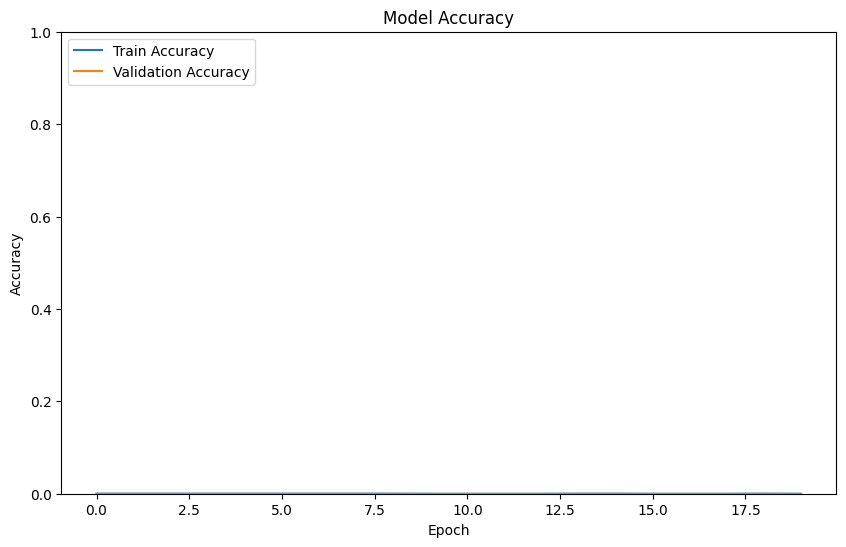

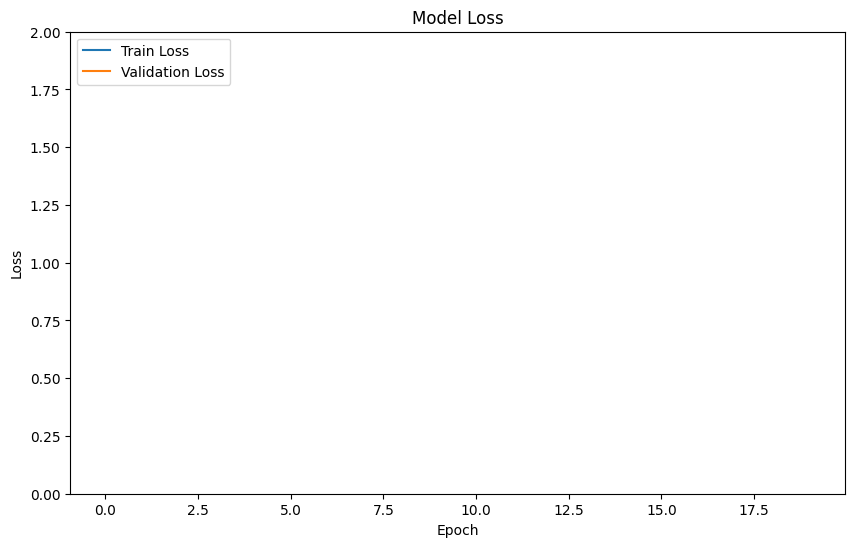

In [ ]:
blstm = BLSTM("graph2vec/features/embledding_cwe_469.csv")
blstm.train()

In [ ]:
blstm.test()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: -1361193.0000
Test loss: -1430145.875
Test accuracy: 0.0
Test AUC: 0.0
